In [1]:
import os
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D, ZeroPadding2D, Conv2DTranspose
from keras.models import Model
from keras.losses import binary_crossentropy
from tensorflow.keras.optimizers import Adam
import keras
import tensorflow as tf


2023-07-31 13:44:03.740577: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-31 13:44:07.564756: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/aaslan/venv-jupyter-310/lib/python3.8/site-packages/cv2/../../lib64:
2023-07-31 13:44:07.564918: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/aaslan/venv-jupyter-310/lib/python3.8/site-packag

In [2]:
SIZE = 256
image_s =[]
dataset_s=[]
image_labels = []
image_directory_2  = 'good/'
good_images_2 = os.listdir(image_directory_2)
for i, image_name in enumerate(good_images_2):
    if (image_name.endswith('png')):
        image_s = cv2.imread(image_directory_2 + image_name)
        image_s = Image.fromarray(image_s,'RGB')
        image_s = image_s.resize((SIZE, SIZE)) 
        dataset_s.append(np.array(image_s))
dataset_s = np.array(dataset_s)
train_x = dataset_s[0:450]
train_x = train_x.astype('float32') / 255.
val_x = dataset_s[450:500]
val_x = val_x.astype('float32') / 255.
test_good_x = dataset_s[450:500]
test_good_x = test_good_x.astype('float32') / 255.

In [4]:
#VGG19 Teacher
input_shape = (256, 256, 3)
teacher_model = tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_shape=input_shape)

block1_conv2_output = teacher_model.get_layer('block1_conv2').output
block2_conv2_output = teacher_model.get_layer('block2_conv2').output
block3_conv3_output = teacher_model.get_layer('block3_conv4').output

t_model = Model(inputs=teacher_model.input, outputs=[block1_conv2_output, block2_conv2_output, block3_conv3_output])
t_model.compile(loss='mse', optimizer='Adam')

In [5]:
#VGG19 Student
student_model = tf.keras.applications.VGG19(weights=None, include_top=False, input_shape=input_shape)
input_tensor = student_model.input
student_block1_conv2 = student_model.get_layer('block1_conv2').output
student_block2_conv2 = student_model.get_layer('block2_conv2').output
student_block3_conv3 = student_model.get_layer('block3_conv4').output

student_model = Model(inputs=input_tensor,
                      outputs=[student_block1_conv2, student_block2_conv2, student_block3_conv3])
student_model.compile(loss='mse', optimizer='Adam')

In [33]:
student_model.save('stmd_final.h5')

In [21]:
student_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [149]:
import time
start_time = time.time()
loss_fns = [tf.keras.losses.MeanSquaredError(), tf.keras.losses.MeanSquaredError(), tf.keras.losses.MeanSquaredError()]
s_loss_list = [[] for _ in range(len(loss_fns))]  # create a list to store losses for each branch
val_loss_list = [[] for _ in range(len(loss_fns))]  # create a list to store validation losses for each branch
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

for epoch in range(1000):
    for i in range(0, len(train_x), 32):
        with tf.GradientTape() as tape:
            batch = train_x[i:i+32]
            t_features = t_model(batch)
            s_features = student_model(batch)
            # Compute the feature pyramid matching loss
            total_loss = 0.0
            for j in range(len(t_features)):
                s_feature = s_features[j]
                t_feature = t_features[j]
                loss = loss_fns[j](s_feature, t_feature)
                total_loss += loss
                s_loss_list[j].append(loss.numpy())  # append loss to the list for the current branch
            gradients = tape.gradient(total_loss, student_model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, student_model.trainable_variables))

    # Calculate validation loss for each branch
    val_t_features = t_model(val_x)
    val_s_features = student_model(val_x)
    for j in range(len(val_t_features)):
        val_s_feature = val_s_features[j]
        val_t_feature = val_t_features[j]
        val_loss = loss_fns[j](val_s_feature, val_t_feature)
        val_loss_list[j].append(val_loss.numpy())

    print(f'Epoch {epoch+1} - Student loss for branch 1: {np.mean(s_loss_list[0])}, loss for branch 2: {np.mean(s_loss_list[1])}, loss for branch 3: {np.mean(s_loss_list[2])}')
    print(f'Epoch {epoch+1} - Validation loss for branch 1: {np.mean(val_loss_list[0])}, loss for branch 2: {np.mean(val_loss_list[1])}, loss for branch 3: {np.mean(val_loss_list[2])}')
end = time.time()

print('total time', end-start_time)

Epoch 1 - Student loss for branch 1: 5.169844627380371, loss for branch 2: 5.629122257232666, loss for branch 3: 94.79220581054688
Epoch 1 - Validation loss for branch 1: 5.18321418762207, loss for branch 2: 5.623389720916748, loss for branch 3: 73.73845672607422
Epoch 2 - Student loss for branch 1: 5.171224594116211, loss for branch 2: 5.581638813018799, loss for branch 3: 66.25100708007812
Epoch 2 - Validation loss for branch 1: 5.183065414428711, loss for branch 2: 5.596213340759277, loss for branch 3: 51.81966018676758
Epoch 3 - Student loss for branch 1: 5.1738409996032715, loss for branch 2: 5.569272518157959, loss for branch 3: 53.123443603515625
Epoch 3 - Validation loss for branch 1: 5.183161735534668, loss for branch 2: 5.579679012298584, loss for branch 3: 42.99172592163086
Epoch 4 - Student loss for branch 1: 5.174937725067139, loss for branch 2: 5.557382106781006, loss for branch 3: 46.02355194091797
Epoch 4 - Validation loss for branch 1: 5.182194709777832, loss for branc

Epoch 32 - Student loss for branch 1: 4.79813814163208, loss for branch 2: 2.2242140769958496, loss for branch 3: 17.788734436035156
Epoch 32 - Validation loss for branch 1: 4.781924247741699, loss for branch 2: 2.1519699096679688, loss for branch 3: 16.688358306884766
Epoch 33 - Student loss for branch 1: 4.772984504699707, loss for branch 2: 2.181976556777954, loss for branch 3: 17.482446670532227
Epoch 33 - Validation loss for branch 1: 4.755558013916016, loss for branch 2: 2.111968517303467, loss for branch 3: 16.41214942932129
Epoch 34 - Student loss for branch 1: 4.74604606628418, loss for branch 2: 2.142089366912842, loss for branch 3: 17.190156936645508
Epoch 34 - Validation loss for branch 1: 4.727160453796387, loss for branch 2: 2.0742499828338623, loss for branch 3: 16.162952423095703
Epoch 35 - Student loss for branch 1: 4.7180562019348145, loss for branch 2: 2.1059815883636475, loss for branch 3: 17.065185546875
Epoch 35 - Validation loss for branch 1: 4.699798107147217, l

Epoch 63 - Student loss for branch 1: 3.835367202758789, loss for branch 2: 1.557039737701416, loss for branch 3: 12.645889282226562
Epoch 63 - Validation loss for branch 1: 3.8064520359039307, loss for branch 2: 1.5209046602249146, loss for branch 3: 12.031170845031738
Epoch 64 - Student loss for branch 1: 3.800170660018921, loss for branch 2: 1.543791651725769, loss for branch 3: 12.5249605178833
Epoch 64 - Validation loss for branch 1: 3.771162986755371, loss for branch 2: 1.5081737041473389, loss for branch 3: 11.919866561889648
Epoch 65 - Student loss for branch 1: 3.7651169300079346, loss for branch 2: 1.5306181907653809, loss for branch 3: 12.407598495483398
Epoch 65 - Validation loss for branch 1: 3.7360615730285645, loss for branch 2: 1.4953033924102783, loss for branch 3: 11.811452865600586
Epoch 66 - Student loss for branch 1: 3.7302627563476562, loss for branch 2: 1.517521858215332, loss for branch 3: 12.295494079589844
Epoch 66 - Validation loss for branch 1: 3.70120286941

Epoch 94 - Student loss for branch 1: 2.9297378063201904, loss for branch 2: 1.2388721704483032, loss for branch 3: 10.06382942199707
Epoch 94 - Validation loss for branch 1: 2.9062061309814453, loss for branch 2: 1.2143303155899048, loss for branch 3: 9.6516752243042
Epoch 95 - Student loss for branch 1: 2.9076075553894043, loss for branch 2: 1.2313942909240723, loss for branch 3: 10.006918907165527
Epoch 95 - Validation loss for branch 1: 2.884291887283325, loss for branch 2: 1.2071120738983154, loss for branch 3: 9.599366188049316
Epoch 96 - Student loss for branch 1: 2.8858447074890137, loss for branch 2: 1.2240240573883057, loss for branch 3: 9.951069831848145
Epoch 96 - Validation loss for branch 1: 2.862741470336914, loss for branch 2: 1.2000058889389038, loss for branch 3: 9.548233985900879
Epoch 97 - Student loss for branch 1: 2.864439010620117, loss for branch 2: 1.2167726755142212, loss for branch 3: 9.896624565124512
Epoch 97 - Validation loss for branch 1: 2.84154605865478

Epoch 125 - Student loss for branch 1: 2.379028797149658, loss for branch 2: 1.052079439163208, loss for branch 3: 8.72619342803955
Epoch 125 - Validation loss for branch 1: 2.3607723712921143, loss for branch 2: 1.0338443517684937, loss for branch 3: 8.42186450958252
Epoch 126 - Student loss for branch 1: 2.364866018295288, loss for branch 2: 1.0472973585128784, loss for branch 3: 8.695048332214355
Epoch 126 - Validation loss for branch 1: 2.34674072265625, loss for branch 2: 1.0293214321136475, loss for branch 3: 8.39295768737793
Epoch 127 - Student loss for branch 1: 2.350877046585083, loss for branch 2: 1.042609453201294, loss for branch 3: 8.663337707519531
Epoch 127 - Validation loss for branch 1: 2.332880973815918, loss for branch 2: 1.024724006652832, loss for branch 3: 8.363485336303711
Epoch 128 - Student loss for branch 1: 2.3370566368103027, loss for branch 2: 1.0379111766815186, loss for branch 3: 8.6318359375
Epoch 128 - Validation loss for branch 1: 2.319186210632324, lo

Epoch 156 - Student loss for branch 1: 2.006333351135254, loss for branch 2: 0.9250591397285461, loss for branch 3: 7.916382789611816
Epoch 156 - Validation loss for branch 1: 1.991379976272583, loss for branch 2: 0.9107495546340942, loss for branch 3: 7.678232192993164
Epoch 157 - Student loss for branch 1: 1.9962165355682373, loss for branch 2: 0.9216462969779968, loss for branch 3: 7.895416259765625
Epoch 157 - Validation loss for branch 1: 1.9813508987426758, loss for branch 2: 0.9074437022209167, loss for branch 3: 7.659075736999512
Epoch 158 - Student loss for branch 1: 1.9861993789672852, loss for branch 2: 0.9182651042938232, loss for branch 3: 7.874612808227539
Epoch 158 - Validation loss for branch 1: 1.9714205265045166, loss for branch 2: 0.9041634202003479, loss for branch 3: 7.639936447143555
Epoch 159 - Student loss for branch 1: 1.9762805700302124, loss for branch 2: 0.9149256348609924, loss for branch 3: 7.85445499420166
Epoch 159 - Validation loss for branch 1: 1.96158

Epoch 187 - Student loss for branch 1: 1.8257334232330322, loss for branch 2: 1.1223936080932617, loss for branch 3: 8.369601249694824
Epoch 187 - Validation loss for branch 1: 1.8136167526245117, loss for branch 2: 1.122109293937683, loss for branch 3: 8.24242115020752
Epoch 188 - Student loss for branch 1: 1.8194338083267212, loss for branch 2: 1.1262707710266113, loss for branch 3: 8.341643333435059
Epoch 188 - Validation loss for branch 1: 1.8073618412017822, loss for branch 2: 1.125985860824585, loss for branch 3: 8.213698387145996
Epoch 189 - Student loss for branch 1: 1.8131552934646606, loss for branch 2: 1.1300535202026367, loss for branch 3: 8.312583923339844
Epoch 189 - Validation loss for branch 1: 1.8011380434036255, loss for branch 2: 1.1298381090164185, loss for branch 3: 8.196100234985352
Epoch 190 - Student loss for branch 1: 1.8069020509719849, loss for branch 2: 1.1337907314300537, loss for branch 3: 8.285438537597656
Epoch 190 - Validation loss for branch 1: 1.79493

Epoch 218 - Student loss for branch 1: 1.6426200866699219, loss for branch 2: 1.2094099521636963, loss for branch 3: 7.548771381378174
Epoch 218 - Validation loss for branch 1: 1.6319780349731445, loss for branch 2: 1.209503412246704, loss for branch 3: 7.455419063568115
Epoch 219 - Student loss for branch 1: 1.6372984647750854, loss for branch 2: 1.2117459774017334, loss for branch 3: 7.526154518127441
Epoch 219 - Validation loss for branch 1: 1.6266900300979614, loss for branch 2: 1.2118111848831177, loss for branch 3: 7.432596206665039
Epoch 220 - Student loss for branch 1: 1.631993055343628, loss for branch 2: 1.2139731645584106, loss for branch 3: 7.502679824829102
Epoch 220 - Validation loss for branch 1: 1.6214206218719482, loss for branch 2: 1.2140247821807861, loss for branch 3: 7.409576892852783
Epoch 221 - Student loss for branch 1: 1.626710057258606, loss for branch 2: 1.2161282300949097, loss for branch 3: 7.4789838790893555
Epoch 221 - Validation loss for branch 1: 1.6161

Epoch 249 - Student loss for branch 1: 1.4902963638305664, loss for branch 2: 1.2636452913284302, loss for branch 3: 6.878294467926025
Epoch 249 - Validation loss for branch 1: 1.4808655977249146, loss for branch 2: 1.2640143632888794, loss for branch 3: 6.802398204803467
Epoch 250 - Student loss for branch 1: 1.4858317375183105, loss for branch 2: 1.2649296522140503, loss for branch 3: 6.858828544616699
Epoch 250 - Validation loss for branch 1: 1.4764357805252075, loss for branch 2: 1.2653071880340576, loss for branch 3: 6.783316135406494
Epoch 251 - Student loss for branch 1: 1.481390357017517, loss for branch 2: 1.2661844491958618, loss for branch 3: 6.8395094871521
Epoch 251 - Validation loss for branch 1: 1.4720289707183838, loss for branch 2: 1.2665655612945557, loss for branch 3: 6.764388561248779
Epoch 252 - Student loss for branch 1: 1.4769723415374756, loss for branch 2: 1.2673636674880981, loss for branch 3: 6.820353984832764
Epoch 252 - Validation loss for branch 1: 1.46764

Epoch 280 - Student loss for branch 1: 1.3633143901824951, loss for branch 2: 1.2896654605865479, loss for branch 3: 6.339598178863525
Epoch 280 - Validation loss for branch 1: 1.3549202680587769, loss for branch 2: 1.2902616262435913, loss for branch 3: 6.277596950531006
Epoch 281 - Student loss for branch 1: 1.3595978021621704, loss for branch 2: 1.290231466293335, loss for branch 3: 6.324138164520264
Epoch 281 - Validation loss for branch 1: 1.3512346744537354, loss for branch 2: 1.2908366918563843, loss for branch 3: 6.2623982429504395
Epoch 282 - Student loss for branch 1: 1.3559041023254395, loss for branch 2: 1.2907854318618774, loss for branch 3: 6.308718204498291
Epoch 282 - Validation loss for branch 1: 1.3475697040557861, loss for branch 2: 1.2914025783538818, loss for branch 3: 6.247377872467041
Epoch 283 - Student loss for branch 1: 1.3522331714630127, loss for branch 2: 1.2913308143615723, loss for branch 3: 6.293430805206299
Epoch 283 - Validation loss for branch 1: 1.34

Epoch 311 - Student loss for branch 1: 1.2584288120269775, loss for branch 2: 1.3025662899017334, loss for branch 3: 5.904277801513672
Epoch 311 - Validation loss for branch 1: 1.2509273290634155, loss for branch 2: 1.3034775257110596, loss for branch 3: 5.851608753204346
Epoch 312 - Student loss for branch 1: 1.2553752660751343, loss for branch 2: 1.3028244972229004, loss for branch 3: 5.891665935516357
Epoch 312 - Validation loss for branch 1: 1.247900366783142, loss for branch 2: 1.303731083869934, loss for branch 3: 5.839382171630859
Epoch 313 - Student loss for branch 1: 1.252341389656067, loss for branch 2: 1.3030524253845215, loss for branch 3: 5.879420280456543
Epoch 313 - Validation loss for branch 1: 1.244893193244934, loss for branch 2: 1.3039772510528564, loss for branch 3: 5.8278398513793945
Epoch 314 - Student loss for branch 1: 1.2493269443511963, loss for branch 2: 1.303276777267456, loss for branch 3: 5.86712121963501
Epoch 314 - Validation loss for branch 1: 1.2419048

Epoch 342 - Student loss for branch 1: 1.1719181537628174, loss for branch 2: 1.3064292669296265, loss for branch 3: 5.547372341156006
Epoch 342 - Validation loss for branch 1: 1.1651602983474731, loss for branch 2: 1.3075478076934814, loss for branch 3: 5.502241134643555
Epoch 343 - Student loss for branch 1: 1.1693850755691528, loss for branch 2: 1.3062950372695923, loss for branch 3: 5.536953449249268
Epoch 343 - Validation loss for branch 1: 1.1626490354537964, loss for branch 2: 1.3074113130569458, loss for branch 3: 5.491973400115967
Epoch 344 - Student loss for branch 1: 1.1668670177459717, loss for branch 2: 1.3061394691467285, loss for branch 3: 5.526493072509766
Epoch 344 - Validation loss for branch 1: 1.160152554512024, loss for branch 2: 1.3072597980499268, loss for branch 3: 5.481738567352295
Epoch 345 - Student loss for branch 1: 1.1643632650375366, loss for branch 2: 1.3059735298156738, loss for branch 3: 5.516096115112305
Epoch 345 - Validation loss for branch 1: 1.157

Epoch 373 - Student loss for branch 1: 1.0995852947235107, loss for branch 2: 1.3000279664993286, loss for branch 3: 5.246723651885986
Epoch 373 - Validation loss for branch 1: 1.0934431552886963, loss for branch 2: 1.3013486862182617, loss for branch 3: 5.2075018882751465
Epoch 374 - Student loss for branch 1: 1.0974481105804443, loss for branch 2: 1.2997913360595703, loss for branch 3: 5.237902641296387
Epoch 374 - Validation loss for branch 1: 1.0913240909576416, loss for branch 2: 1.3011177778244019, loss for branch 3: 5.198734283447266
Epoch 375 - Student loss for branch 1: 1.0953220129013062, loss for branch 2: 1.2995527982711792, loss for branch 3: 5.22904634475708
Epoch 375 - Validation loss for branch 1: 1.0892161130905151, loss for branch 2: 1.3008859157562256, loss for branch 3: 5.190127372741699
Epoch 376 - Student loss for branch 1: 1.0932073593139648, loss for branch 2: 1.299314022064209, loss for branch 3: 5.220238208770752
Epoch 376 - Validation loss for branch 1: 1.087

Epoch 404 - Student loss for branch 1: 1.0382235050201416, loss for branch 2: 1.2923383712768555, loss for branch 3: 4.995828151702881
Epoch 404 - Validation loss for branch 1: 1.0326039791107178, loss for branch 2: 1.2938671112060547, loss for branch 3: 4.963592052459717
Epoch 405 - Student loss for branch 1: 1.0363976955413818, loss for branch 2: 1.2919694185256958, loss for branch 3: 4.988150119781494
Epoch 405 - Validation loss for branch 1: 1.03079354763031, loss for branch 2: 1.2935034036636353, loss for branch 3: 4.956046104431152
Epoch 406 - Student loss for branch 1: 1.0345807075500488, loss for branch 2: 1.2916009426116943, loss for branch 3: 4.980506896972656
Epoch 406 - Validation loss for branch 1: 1.0289920568466187, loss for branch 2: 1.293139934539795, loss for branch 3: 4.948539733886719
Epoch 407 - Student loss for branch 1: 1.032772421836853, loss for branch 2: 1.2912328243255615, loss for branch 3: 4.972902774810791
Epoch 407 - Validation loss for branch 1: 1.027199

Epoch 435 - Student loss for branch 1: 0.9854663610458374, loss for branch 2: 1.2812601327896118, loss for branch 3: 4.77415132522583
Epoch 435 - Validation loss for branch 1: 0.9802947640419006, loss for branch 2: 1.282924771308899, loss for branch 3: 4.746057033538818
Epoch 436 - Student loss for branch 1: 0.9839015007019043, loss for branch 2: 1.281169056892395, loss for branch 3: 4.779753684997559
Epoch 436 - Validation loss for branch 1: 0.9788864850997925, loss for branch 2: 1.284117579460144, loss for branch 3: 4.793988227844238
Epoch 437 - Student loss for branch 1: 0.982702374458313, loss for branch 2: 1.2838634252548218, loss for branch 3: 4.809032917022705
Epoch 437 - Validation loss for branch 1: 0.9777830839157104, loss for branch 2: 1.286520004272461, loss for branch 3: 4.80714750289917
Epoch 438 - Student loss for branch 1: 0.9815557599067688, loss for branch 2: 1.2857115268707275, loss for branch 3: 4.815944671630859
Epoch 438 - Validation loss for branch 1: 0.976631939

Epoch 466 - Student loss for branch 1: 0.9468422532081604, loss for branch 2: 1.3170286417007446, loss for branch 3: 4.747219085693359
Epoch 466 - Validation loss for branch 1: 0.9421452879905701, loss for branch 2: 1.319146990776062, loss for branch 3: 4.72151517868042
Epoch 467 - Student loss for branch 1: 0.945586085319519, loss for branch 2: 1.3176372051239014, loss for branch 3: 4.741052627563477
Epoch 467 - Validation loss for branch 1: 0.940899670124054, loss for branch 2: 1.3197569847106934, loss for branch 3: 4.715439796447754
Epoch 468 - Student loss for branch 1: 0.9443333148956299, loss for branch 2: 1.3182358741760254, loss for branch 3: 4.734894752502441
Epoch 468 - Validation loss for branch 1: 0.9396575093269348, loss for branch 2: 1.320357322692871, loss for branch 3: 4.709375858306885
Epoch 469 - Student loss for branch 1: 0.9430840611457825, loss for branch 2: 1.3188258409500122, loss for branch 3: 4.728767395019531
Epoch 469 - Validation loss for branch 1: 0.9384188

Epoch 497 - Student loss for branch 1: 0.9097198247909546, loss for branch 2: 1.333168387413025, loss for branch 3: 4.56209659576416
Epoch 497 - Validation loss for branch 1: 0.9053409099578857, loss for branch 2: 1.3353941440582275, loss for branch 3: 4.539138317108154
Epoch 498 - Student loss for branch 1: 0.9085757732391357, loss for branch 2: 1.3336246013641357, loss for branch 3: 4.556413650512695
Epoch 498 - Validation loss for branch 1: 0.9042059779167175, loss for branch 2: 1.3358546495437622, loss for branch 3: 4.533583641052246
Epoch 499 - Student loss for branch 1: 0.907434344291687, loss for branch 2: 1.334078311920166, loss for branch 3: 4.550771236419678
Epoch 499 - Validation loss for branch 1: 0.9030739665031433, loss for branch 2: 1.3363128900527954, loss for branch 3: 4.527988433837891
Epoch 500 - Student loss for branch 1: 0.9062957167625427, loss for branch 2: 1.3345293998718262, loss for branch 3: 4.545108318328857
Epoch 500 - Validation loss for branch 1: 0.901944

Epoch 528 - Student loss for branch 1: 0.8756028413772583, loss for branch 2: 1.3461062908172607, loss for branch 3: 4.394551753997803
Epoch 528 - Validation loss for branch 1: 0.8715013861656189, loss for branch 2: 1.3484512567520142, loss for branch 3: 4.374229431152344
Epoch 529 - Student loss for branch 1: 0.8745467066764832, loss for branch 2: 1.3464875221252441, loss for branch 3: 4.38943338394165
Epoch 529 - Validation loss for branch 1: 0.8704538345336914, loss for branch 2: 1.348836064338684, loss for branch 3: 4.369199752807617
Epoch 530 - Student loss for branch 1: 0.873493492603302, loss for branch 2: 1.3468667268753052, loss for branch 3: 4.384332656860352
Epoch 530 - Validation loss for branch 1: 0.8694092035293579, loss for branch 2: 1.349218487739563, loss for branch 3: 4.364180564880371
Epoch 531 - Student loss for branch 1: 0.8724431991577148, loss for branch 2: 1.3472431898117065, loss for branch 3: 4.379256725311279
Epoch 531 - Validation loss for branch 1: 0.868367

Epoch 559 - Student loss for branch 1: 0.8441540002822876, loss for branch 2: 1.3570246696472168, loss for branch 3: 4.244427680969238
Epoch 559 - Validation loss for branch 1: 0.8403063416481018, loss for branch 2: 1.359477162361145, loss for branch 3: 4.2268595695495605
Epoch 560 - Student loss for branch 1: 0.843189537525177, loss for branch 2: 1.3573510646820068, loss for branch 3: 4.239838600158691
Epoch 560 - Validation loss for branch 1: 0.8393496870994568, loss for branch 2: 1.359806776046753, loss for branch 3: 4.222352981567383
Epoch 561 - Student loss for branch 1: 0.8422282934188843, loss for branch 2: 1.3576759099960327, loss for branch 3: 4.235276699066162
Epoch 561 - Validation loss for branch 1: 0.838396430015564, loss for branch 2: 1.3601351976394653, loss for branch 3: 4.217865467071533
Epoch 562 - Student loss for branch 1: 0.841270387172699, loss for branch 2: 1.357999324798584, loss for branch 3: 4.230720520019531
Epoch 562 - Validation loss for branch 1: 0.8374463

Epoch 590 - Student loss for branch 1: 0.815710186958313, loss for branch 2: 1.3663582801818848, loss for branch 3: 4.109898567199707
Epoch 590 - Validation loss for branch 1: 0.81209796667099, loss for branch 2: 1.3688632249832153, loss for branch 3: 4.095013618469238
Epoch 591 - Student loss for branch 1: 0.8148418664932251, loss for branch 2: 1.366573691368103, loss for branch 3: 4.10581111907959
Epoch 591 - Validation loss for branch 1: 0.811236560344696, loss for branch 2: 1.3690810203552246, loss for branch 3: 4.090961456298828
Epoch 592 - Student loss for branch 1: 0.8139758110046387, loss for branch 2: 1.3667867183685303, loss for branch 3: 4.101693630218506
Epoch 592 - Validation loss for branch 1: 0.8103773593902588, loss for branch 2: 1.3692959547042847, loss for branch 3: 4.0868916511535645
Epoch 593 - Student loss for branch 1: 0.813112199306488, loss for branch 2: 1.3669973611831665, loss for branch 3: 4.0975775718688965
Epoch 593 - Validation loss for branch 1: 0.8095207

Epoch 621 - Student loss for branch 1: 0.7899971008300781, loss for branch 2: 1.3708884716033936, loss for branch 3: 3.9879150390625
Epoch 621 - Validation loss for branch 1: 0.7865943908691406, loss for branch 2: 1.3734387159347534, loss for branch 3: 3.97525691986084
Epoch 622 - Student loss for branch 1: 0.7892083525657654, loss for branch 2: 1.370992660522461, loss for branch 3: 3.9841768741607666
Epoch 622 - Validation loss for branch 1: 0.7858120799064636, loss for branch 2: 1.3735454082489014, loss for branch 3: 3.9716153144836426
Epoch 623 - Student loss for branch 1: 0.7884221076965332, loss for branch 2: 1.371095895767212, loss for branch 3: 3.9804675579071045
Epoch 623 - Validation loss for branch 1: 0.785032331943512, loss for branch 2: 1.373651146888733, loss for branch 3: 3.9679670333862305
Epoch 624 - Student loss for branch 1: 0.7876383662223816, loss for branch 2: 1.3711978197097778, loss for branch 3: 3.976750612258911
Epoch 624 - Validation loss for branch 1: 0.78425

Epoch 652 - Student loss for branch 1: 0.7666382193565369, loss for branch 2: 1.3721084594726562, loss for branch 3: 3.877709150314331
Epoch 652 - Validation loss for branch 1: 0.7634257674217224, loss for branch 2: 1.3747035264968872, loss for branch 3: 3.866692066192627
Epoch 653 - Student loss for branch 1: 0.7659198045730591, loss for branch 2: 1.3721282482147217, loss for branch 3: 3.874293804168701
Epoch 653 - Validation loss for branch 1: 0.7627131938934326, loss for branch 2: 1.3747258186340332, loss for branch 3: 3.863342523574829
Epoch 654 - Student loss for branch 1: 0.7652035355567932, loss for branch 2: 1.3721476793289185, loss for branch 3: 3.8708994388580322
Epoch 654 - Validation loss for branch 1: 0.7620026469230652, loss for branch 2: 1.3747477531433105, loss for branch 3: 3.8599886894226074
Epoch 655 - Student loss for branch 1: 0.7644892334938049, loss for branch 2: 1.3721668720245361, loss for branch 3: 3.867504835128784
Epoch 655 - Validation loss for branch 1: 0.

Epoch 682 - Student loss for branch 1: 0.7459124326705933, loss for branch 2: 1.3725924491882324, loss for branch 3: 3.7799017429351807
Epoch 682 - Validation loss for branch 1: 0.7428641319274902, loss for branch 2: 1.3752611875534058, loss for branch 3: 3.7705328464508057
Epoch 683 - Student loss for branch 1: 0.7452481389045715, loss for branch 2: 1.3726052045822144, loss for branch 3: 3.7767977714538574
Epoch 683 - Validation loss for branch 1: 0.7422050833702087, loss for branch 2: 1.3752760887145996, loss for branch 3: 3.7674641609191895
Epoch 684 - Student loss for branch 1: 0.7445855736732483, loss for branch 2: 1.372617483139038, loss for branch 3: 3.773698568344116
Epoch 684 - Validation loss for branch 1: 0.7415479421615601, loss for branch 2: 1.3752906322479248, loss for branch 3: 3.7644317150115967
Epoch 685 - Student loss for branch 1: 0.7439250349998474, loss for branch 2: 1.3726292848587036, loss for branch 3: 3.7706143856048584
Epoch 685 - Validation loss for branch 1:

Epoch 713 - Student loss for branch 1: 0.7261412739753723, loss for branch 2: 1.3728221654891968, loss for branch 3: 3.687429904937744
Epoch 713 - Validation loss for branch 1: 0.7232499122619629, loss for branch 2: 1.3755570650100708, loss for branch 3: 3.6797163486480713
Epoch 714 - Student loss for branch 1: 0.7255305647850037, loss for branch 2: 1.3728251457214355, loss for branch 3: 3.6845686435699463
Epoch 714 - Validation loss for branch 1: 0.722644031047821, loss for branch 2: 1.3755621910095215, loss for branch 3: 3.6769230365753174
Epoch 715 - Student loss for branch 1: 0.7249215245246887, loss for branch 2: 1.3728281259536743, loss for branch 3: 3.681753396987915
Epoch 715 - Validation loss for branch 1: 0.7220398187637329, loss for branch 2: 1.3755675554275513, loss for branch 3: 3.674173593521118
Epoch 716 - Student loss for branch 1: 0.7243140935897827, loss for branch 2: 1.372830867767334, loss for branch 3: 3.6789214611053467
Epoch 716 - Validation loss for branch 1: 0.

Epoch 743 - Student loss for branch 1: 0.7084954977035522, loss for branch 2: 1.3727999925613403, loss for branch 3: 3.6051270961761475
Epoch 743 - Validation loss for branch 1: 0.7057430148124695, loss for branch 2: 1.375591516494751, loss for branch 3: 3.5989127159118652
Epoch 744 - Student loss for branch 1: 0.7079303860664368, loss for branch 2: 1.3727911710739136, loss for branch 3: 3.602499485015869
Epoch 744 - Validation loss for branch 1: 0.7051824927330017, loss for branch 2: 1.3755844831466675, loss for branch 3: 3.5963292121887207
Epoch 745 - Student loss for branch 1: 0.7073668837547302, loss for branch 2: 1.372781753540039, loss for branch 3: 3.599874973297119
Epoch 745 - Validation loss for branch 1: 0.704623281955719, loss for branch 2: 1.3755766153335571, loss for branch 3: 3.593745470046997
Epoch 746 - Student loss for branch 1: 0.7068046927452087, loss for branch 2: 1.3727716207504272, loss for branch 3: 3.5972518920898438
Epoch 746 - Validation loss for branch 1: 0.7

Epoch 773 - Student loss for branch 1: 0.6921452283859253, loss for branch 2: 1.3723080158233643, loss for branch 3: 3.529149055480957
Epoch 773 - Validation loss for branch 1: 0.6895209550857544, loss for branch 2: 1.3751357793807983, loss for branch 3: 3.5242626667022705
Epoch 774 - Student loss for branch 1: 0.6916208267211914, loss for branch 2: 1.3722562789916992, loss for branch 3: 3.526759386062622
Epoch 774 - Validation loss for branch 1: 0.6890007257461548, loss for branch 2: 1.375083327293396, loss for branch 3: 3.521956205368042
Epoch 775 - Student loss for branch 1: 0.6910977959632874, loss for branch 2: 1.3722009658813477, loss for branch 3: 3.5243799686431885
Epoch 775 - Validation loss for branch 1: 0.6884817481040955, loss for branch 2: 1.375028371810913, loss for branch 3: 3.519547700881958
Epoch 776 - Student loss for branch 1: 0.6905760169029236, loss for branch 2: 1.372144103050232, loss for branch 3: 3.5219428539276123
Epoch 776 - Validation loss for branch 1: 0.68

Epoch 803 - Student loss for branch 1: 0.676953911781311, loss for branch 2: 1.3704982995986938, loss for branch 3: 3.458653211593628
Epoch 803 - Validation loss for branch 1: 0.6744483113288879, loss for branch 2: 1.3733664751052856, loss for branch 3: 3.454857349395752
Epoch 804 - Student loss for branch 1: 0.6764662861824036, loss for branch 2: 1.3704339265823364, loss for branch 3: 3.4563870429992676
Epoch 804 - Validation loss for branch 1: 0.6739643812179565, loss for branch 2: 1.3733034133911133, loss for branch 3: 3.4526193141937256
Epoch 805 - Student loss for branch 1: 0.675979733467102, loss for branch 2: 1.3703694343566895, loss for branch 3: 3.4541256427764893
Epoch 805 - Validation loss for branch 1: 0.6734817028045654, loss for branch 2: 1.3732404708862305, loss for branch 3: 3.450418472290039
Epoch 806 - Student loss for branch 1: 0.6754944324493408, loss for branch 2: 1.3703049421310425, loss for branch 3: 3.4518823623657227
Epoch 806 - Validation loss for branch 1: 0.

Epoch 834 - Student loss for branch 1: 0.6623616814613342, loss for branch 2: 1.3673276901245117, loss for branch 3: 3.391010046005249
Epoch 834 - Validation loss for branch 1: 0.6599696278572083, loss for branch 2: 1.370211124420166, loss for branch 3: 3.388303518295288
Epoch 835 - Student loss for branch 1: 0.6619083881378174, loss for branch 2: 1.3672114610671997, loss for branch 3: 3.3889193534851074
Epoch 835 - Validation loss for branch 1: 0.6595198512077332, loss for branch 2: 1.3700964450836182, loss for branch 3: 3.3862578868865967
Epoch 836 - Student loss for branch 1: 0.6614560484886169, loss for branch 2: 1.3670955896377563, loss for branch 3: 3.3868205547332764
Epoch 836 - Validation loss for branch 1: 0.6590710282325745, loss for branch 2: 1.3699815273284912, loss for branch 3: 3.3841755390167236
Epoch 837 - Student loss for branch 1: 0.6610048413276672, loss for branch 2: 1.3669794797897339, loss for branch 3: 3.384716033935547
Epoch 837 - Validation loss for branch 1: 0

Epoch 864 - Student loss for branch 1: 0.6492144465446472, loss for branch 2: 1.363757610321045, loss for branch 3: 3.3307247161865234
Epoch 864 - Validation loss for branch 1: 0.6469271779060364, loss for branch 2: 1.3666765689849854, loss for branch 3: 3.328728675842285
Epoch 865 - Student loss for branch 1: 0.6487898826599121, loss for branch 2: 1.3636349439620972, loss for branch 3: 3.3287487030029297
Epoch 865 - Validation loss for branch 1: 0.6465057134628296, loss for branch 2: 1.3665549755096436, loss for branch 3: 3.3267781734466553
Epoch 866 - Student loss for branch 1: 0.6483659148216248, loss for branch 2: 1.3635125160217285, loss for branch 3: 3.326777219772339
Epoch 866 - Validation loss for branch 1: 0.6460849046707153, loss for branch 2: 1.3664333820343018, loss for branch 3: 3.3248441219329834
Epoch 867 - Student loss for branch 1: 0.6479427218437195, loss for branch 2: 1.3633899688720703, loss for branch 3: 3.324812889099121
Epoch 867 - Validation loss for branch 1: 0

Epoch 895 - Student loss for branch 1: 0.6364520192146301, loss for branch 2: 1.3588387966156006, loss for branch 3: 3.2720787525177
Epoch 895 - Validation loss for branch 1: 0.6342631578445435, loss for branch 2: 1.3617498874664307, loss for branch 3: 3.270890474319458
Epoch 896 - Student loss for branch 1: 0.6360543370246887, loss for branch 2: 1.3586547374725342, loss for branch 3: 3.270232915878296
Epoch 896 - Validation loss for branch 1: 0.6338685154914856, loss for branch 2: 1.3615665435791016, loss for branch 3: 3.2690773010253906
Epoch 897 - Student loss for branch 1: 0.635657548904419, loss for branch 2: 1.3584709167480469, loss for branch 3: 3.268392562866211
Epoch 897 - Validation loss for branch 1: 0.6334747076034546, loss for branch 2: 1.361383080482483, loss for branch 3: 3.2672574520111084
Epoch 898 - Student loss for branch 1: 0.635261595249176, loss for branch 2: 1.3582872152328491, loss for branch 3: 3.2665557861328125
Epoch 898 - Validation loss for branch 1: 0.6330

Epoch 925 - Student loss for branch 1: 0.6250141263008118, loss for branch 2: 1.352320909500122, loss for branch 3: 3.2218668460845947
Epoch 925 - Validation loss for branch 1: 0.6229027509689331, loss for branch 2: 1.3551905155181885, loss for branch 3: 3.2232489585876465
Epoch 926 - Student loss for branch 1: 0.6246417164802551, loss for branch 2: 1.3520811796188354, loss for branch 3: 3.22013521194458
Epoch 926 - Validation loss for branch 1: 0.6225332021713257, loss for branch 2: 1.354947805404663, loss for branch 3: 3.2215325832366943
Epoch 927 - Student loss for branch 1: 0.6242701411247253, loss for branch 2: 1.3517996072769165, loss for branch 3: 3.2185146808624268
Epoch 927 - Validation loss for branch 1: 0.6221647262573242, loss for branch 2: 1.3546395301818848, loss for branch 3: 3.2200093269348145
Epoch 928 - Student loss for branch 1: 0.6238994598388672, loss for branch 2: 1.3514877557754517, loss for branch 3: 3.21689510345459
Epoch 928 - Validation loss for branch 1: 0.6

Epoch 956 - Student loss for branch 1: 0.6137593984603882, loss for branch 2: 1.34098219871521, loss for branch 3: 3.1699798107147217
Epoch 956 - Validation loss for branch 1: 0.6117299795150757, loss for branch 2: 1.3437879085540771, loss for branch 3: 3.1720118522644043
Epoch 957 - Student loss for branch 1: 0.6134017705917358, loss for branch 2: 1.3405901193618774, loss for branch 3: 3.1683473587036133
Epoch 957 - Validation loss for branch 1: 0.611375093460083, loss for branch 2: 1.3433964252471924, loss for branch 3: 3.1704041957855225
Epoch 958 - Student loss for branch 1: 0.6130449175834656, loss for branch 2: 1.3401988744735718, loss for branch 3: 3.1667165756225586
Epoch 958 - Validation loss for branch 1: 0.6110208630561829, loss for branch 2: 1.3430054187774658, loss for branch 3: 3.1687986850738525
Epoch 959 - Student loss for branch 1: 0.6126887202262878, loss for branch 2: 1.3398082256317139, loss for branch 3: 3.165091037750244
Epoch 959 - Validation loss for branch 1: 0

Epoch 986 - Student loss for branch 1: 0.6033372282981873, loss for branch 2: 1.329460859298706, loss for branch 3: 3.122471332550049
Epoch 986 - Validation loss for branch 1: 0.6013864278793335, loss for branch 2: 1.3322776556015015, loss for branch 3: 3.125260591506958
Epoch 987 - Student loss for branch 1: 0.6030004024505615, loss for branch 2: 1.3290835618972778, loss for branch 3: 3.1209263801574707
Epoch 987 - Validation loss for branch 1: 0.6010521650314331, loss for branch 2: 1.3319008350372314, loss for branch 3: 3.123737096786499
Epoch 988 - Student loss for branch 1: 0.6026642918586731, loss for branch 2: 1.328706979751587, loss for branch 3: 3.119399309158325
Epoch 988 - Validation loss for branch 1: 0.6007184982299805, loss for branch 2: 1.3315249681472778, loss for branch 3: 3.1222379207611084
Epoch 989 - Student loss for branch 1: 0.6023287773132324, loss for branch 2: 1.3283312320709229, loss for branch 3: 3.1178741455078125
Epoch 989 - Validation loss for branch 1: 0.6

In [150]:
student_model.save('std_3.h5')

In [5]:
student_model = tf.keras.models.load_model('std_3.h5')

In [5]:
loss_fns = [tf.keras.losses.MeanSquaredError(), tf.keras.losses.MeanSquaredError(), tf.keras.losses.MeanSquaredError()]
s_loss_list = [[] for _ in range(len(loss_fns))]  # create a list to store losses for each branch
val_loss_list = [[] for _ in range(len(loss_fns))]  # create a list to store validation losses for each branch
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

for epoch in range(1000):
    for i in range(0, len(train_x), 32):
        with tf.GradientTape() as tape:
            batch = train_x[i:i+32]
            t_features = t_model(batch)
            s_features = student_model(batch)
            # Compute the feature pyramid matching loss
            total_loss = 0.0
            for j in range(len(t_features)):
                s_feature = s_features[j]
                t_feature = t_features[j]
                loss = loss_fns[j](s_feature, t_feature)
                total_loss += loss
                s_loss_list[j].append(loss.numpy())  # append loss to the list for the current branch
            gradients = tape.gradient(total_loss, student_model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, student_model.trainable_variables))

    # Calculate validation loss for each branch
    val_t_features = t_model(val_x)
    val_s_features = student_model(val_x)
    for j in range(len(val_t_features)):
        val_s_feature = val_s_features[j]
        val_t_feature = val_t_features[j]
        val_loss = loss_fns[j](val_s_feature, val_t_feature)
        val_loss_list[j].append(val_loss.numpy())

    print(f'Epoch {epoch+1} - Student loss for branch 1: {np.mean(s_loss_list[0])}, loss for branch 2: {np.mean(s_loss_list[1])}, loss for branch 3: {np.mean(s_loss_list[2])}')
    print(f'Epoch {epoch+1} - Validation loss for branch 1: {np.mean(val_loss_list[0])}, loss for branch 2: {np.mean(val_loss_list[1])}, loss for branch 3: {np.mean(val_loss_list[2])}')


2023-06-28 21:35:38.437538: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2023-06-28 21:35:38.438628: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.0
2023-06-28 21:35:38.438637: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at ptxas
2023-06-28 21:35:38.438684: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


Epoch 1 - Student loss for branch 1: 5.1365275382995605, loss for branch 2: 5.619848251342773, loss for branch 3: 44.3371467590332
Epoch 1 - Validation loss for branch 1: 5.138524055480957, loss for branch 2: 5.4967041015625, loss for branch 3: 24.2954044342041
Epoch 2 - Student loss for branch 1: 5.138551712036133, loss for branch 2: 5.583314418792725, loss for branch 3: 28.653261184692383
Epoch 2 - Validation loss for branch 1: 5.1291680335998535, loss for branch 2: 5.509607791900635, loss for branch 3: 16.66259765625
Epoch 3 - Student loss for branch 1: 5.133534908294678, loss for branch 2: 5.562978267669678, loss for branch 3: 21.726016998291016
Epoch 3 - Validation loss for branch 1: 5.127388000488281, loss for branch 2: 5.506109714508057, loss for branch 3: 13.525588989257812
Epoch 4 - Student loss for branch 1: 5.12638521194458, loss for branch 2: 5.532221794128418, loss for branch 3: 18.024791717529297
Epoch 4 - Validation loss for branch 1: 5.116507530212402, loss for branch 2

Epoch 32 - Student loss for branch 1: 2.8706650733947754, loss for branch 2: 2.120784044265747, loss for branch 3: 4.415255546569824
Epoch 32 - Validation loss for branch 1: 2.8032212257385254, loss for branch 2: 2.0498015880584717, loss for branch 3: 3.487767219543457
Epoch 33 - Student loss for branch 1: 2.8122618198394775, loss for branch 2: 2.0918116569519043, loss for branch 3: 4.300841331481934
Epoch 33 - Validation loss for branch 1: 2.74656343460083, loss for branch 2: 2.0230712890625, loss for branch 3: 3.4006197452545166
Epoch 34 - Student loss for branch 1: 2.7566797733306885, loss for branch 2: 2.066373109817505, loss for branch 3: 4.205232620239258
Epoch 34 - Validation loss for branch 1: 2.692870616912842, loss for branch 2: 2.0015735626220703, loss for branch 3: 3.3303403854370117
Epoch 35 - Student loss for branch 1: 2.703951358795166, loss for branch 2: 2.0423033237457275, loss for branch 3: 4.106417179107666
Epoch 35 - Validation loss for branch 1: 2.641787052154541, 

Epoch 63 - Student loss for branch 1: 1.7973982095718384, loss for branch 2: 1.5990742444992065, loss for branch 3: 2.4802610874176025
Epoch 63 - Validation loss for branch 1: 1.7605493068695068, loss for branch 2: 1.5632818937301636, loss for branch 3: 2.0098724365234375
Epoch 64 - Student loss for branch 1: 1.7771103382110596, loss for branch 2: 1.5896052122116089, loss for branch 3: 2.4470765590667725
Epoch 64 - Validation loss for branch 1: 1.7408111095428467, loss for branch 2: 1.5543875694274902, loss for branch 3: 1.984144687652588
Epoch 65 - Student loss for branch 1: 1.7573448419570923, loss for branch 2: 1.5803894996643066, loss for branch 3: 2.414849042892456
Epoch 65 - Validation loss for branch 1: 1.7215815782546997, loss for branch 2: 1.5457416772842407, loss for branch 3: 1.9589903354644775
Epoch 66 - Student loss for branch 1: 1.7380844354629517, loss for branch 2: 1.571458101272583, loss for branch 3: 2.3849539756774902
Epoch 66 - Validation loss for branch 1: 1.702848

Epoch 94 - Student loss for branch 1: 1.3875694274902344, loss for branch 2: 1.7349880933761597, loss for branch 3: 2.572481393814087
Epoch 94 - Validation loss for branch 1: 1.3631775379180908, loss for branch 2: 1.720787525177002, loss for branch 3: 2.4709105491638184
Epoch 95 - Student loss for branch 1: 1.3773802518844604, loss for branch 2: 1.7354974746704102, loss for branch 3: 2.5518476963043213
Epoch 95 - Validation loss for branch 1: 1.3532509803771973, loss for branch 2: 1.7214689254760742, loss for branch 3: 2.451397180557251
Epoch 96 - Student loss for branch 1: 1.3673820495605469, loss for branch 2: 1.7359594106674194, loss for branch 3: 2.5315656661987305
Epoch 96 - Validation loss for branch 1: 1.343510627746582, loss for branch 2: 1.7220993041992188, loss for branch 3: 2.4322547912597656
Epoch 97 - Student loss for branch 1: 1.3575702905654907, loss for branch 2: 1.7363784313201904, loss for branch 3: 2.511651039123535
Epoch 97 - Validation loss for branch 1: 1.33395242

Epoch 125 - Student loss for branch 1: 1.142917275428772, loss for branch 2: 1.6892035007476807, loss for branch 3: 2.101731538772583
Epoch 125 - Validation loss for branch 1: 1.1248236894607544, loss for branch 2: 1.6766120195388794, loss for branch 3: 2.023360013961792
Epoch 126 - Student loss for branch 1: 1.1368993520736694, loss for branch 2: 1.6845314502716064, loss for branch 3: 2.08925461769104
Epoch 126 - Validation loss for branch 1: 1.118959665298462, loss for branch 2: 1.6720598936080933, loss for branch 3: 2.011530637741089
Epoch 127 - Student loss for branch 1: 1.1309725046157837, loss for branch 2: 1.679917335510254, loss for branch 3: 2.0769548416137695
Epoch 127 - Validation loss for branch 1: 1.1131844520568848, loss for branch 2: 1.6675639152526855, loss for branch 3: 1.9998693466186523
Epoch 128 - Student loss for branch 1: 1.125134825706482, loss for branch 2: 1.675360083580017, loss for branch 3: 2.0648295879364014
Epoch 128 - Validation loss for branch 1: 1.10749

Epoch 155 - Student loss for branch 1: 0.9949344992637634, loss for branch 2: 1.5642154216766357, loss for branch 3: 1.79420804977417
Epoch 155 - Validation loss for branch 1: 0.9805929660797119, loss for branch 2: 1.5537993907928467, loss for branch 3: 1.731636643409729
Epoch 156 - Student loss for branch 1: 0.9909424781799316, loss for branch 2: 1.5598742961883545, loss for branch 3: 1.7858573198318481
Epoch 156 - Validation loss for branch 1: 0.9767013788223267, loss for branch 2: 1.549540638923645, loss for branch 3: 1.7237122058868408
Epoch 157 - Student loss for branch 1: 0.9869996905326843, loss for branch 2: 1.5555782318115234, loss for branch 3: 1.7776097059249878
Epoch 157 - Validation loss for branch 1: 0.9728577136993408, loss for branch 2: 1.5453263521194458, loss for branch 3: 1.7158868312835693
Epoch 158 - Student loss for branch 1: 0.9831053614616394, loss for branch 2: 1.5513272285461426, loss for branch 3: 1.7694605588912964
Epoch 158 - Validation loss for branch 1: 0

Epoch 185 - Student loss for branch 1: 0.8934319615364075, loss for branch 2: 1.4511295557022095, loss for branch 3: 1.5821657180786133
Epoch 185 - Validation loss for branch 1: 0.8816283941268921, loss for branch 2: 1.4428272247314453, loss for branch 3: 1.5309288501739502
Epoch 186 - Student loss for branch 1: 0.8905894756317139, loss for branch 2: 1.4479057788848877, loss for branch 3: 1.5762572288513184
Epoch 186 - Validation loss for branch 1: 0.8788560628890991, loss for branch 2: 1.4396615028381348, loss for branch 3: 1.525312900543213
Epoch 187 - Student loss for branch 1: 0.8877753615379333, loss for branch 2: 1.4447110891342163, loss for branch 3: 1.5703893899917603
Epoch 187 - Validation loss for branch 1: 0.8761110901832581, loss for branch 2: 1.4365251064300537, loss for branch 3: 1.5197550058364868
Epoch 188 - Student loss for branch 1: 0.8849891424179077, loss for branch 2: 1.4415464401245117, loss for branch 3: 1.5645936727523804
Epoch 188 - Validation loss for branch 1

Epoch 215 - Student loss for branch 1: 0.8191831707954407, loss for branch 2: 1.3651659488677979, loss for branch 3: 1.428581953048706
Epoch 215 - Validation loss for branch 1: 0.8092067837715149, loss for branch 2: 1.3583401441574097, loss for branch 3: 1.385197401046753
Epoch 216 - Student loss for branch 1: 0.8170515894889832, loss for branch 2: 1.362638235092163, loss for branch 3: 1.4241710901260376
Epoch 216 - Validation loss for branch 1: 0.8071274161338806, loss for branch 2: 1.3558562994003296, loss for branch 3: 1.3810228109359741
Epoch 217 - Student loss for branch 1: 0.8149389028549194, loss for branch 2: 1.3601313829421997, loss for branch 3: 1.4197849035263062
Epoch 217 - Validation loss for branch 1: 0.8050666451454163, loss for branch 2: 1.353393316268921, loss for branch 3: 1.3768773078918457
Epoch 218 - Student loss for branch 1: 0.8128451108932495, loss for branch 2: 1.3576467037200928, loss for branch 3: 1.4154540300369263
Epoch 218 - Validation loss for branch 1: 0

Epoch 245 - Student loss for branch 1: 0.7626119256019592, loss for branch 2: 1.2977962493896484, loss for branch 3: 1.311734676361084
Epoch 245 - Validation loss for branch 1: 0.7540189027786255, loss for branch 2: 1.292118787765503, loss for branch 3: 1.2742339372634888
Epoch 246 - Student loss for branch 1: 0.760958194732666, loss for branch 2: 1.2958186864852905, loss for branch 3: 1.3083248138427734
Epoch 246 - Validation loss for branch 1: 0.7524054050445557, loss for branch 2: 1.290174126625061, loss for branch 3: 1.2710113525390625
Epoch 247 - Student loss for branch 1: 0.7593174576759338, loss for branch 2: 1.293857455253601, loss for branch 3: 1.304958701133728
Epoch 247 - Validation loss for branch 1: 0.7508047819137573, loss for branch 2: 1.2882462739944458, loss for branch 3: 1.2677956819534302
Epoch 248 - Student loss for branch 1: 0.7576896548271179, loss for branch 2: 1.291911244392395, loss for branch 3: 1.3016040325164795
Epoch 248 - Validation loss for branch 1: 0.74

Epoch 275 - Student loss for branch 1: 0.7181212902069092, loss for branch 2: 1.2442845106124878, loss for branch 3: 1.22004234790802
Epoch 275 - Validation loss for branch 1: 0.7106103301048279, loss for branch 2: 1.2394973039627075, loss for branch 3: 1.1871486902236938
Epoch 276 - Student loss for branch 1: 0.7168013453483582, loss for branch 2: 1.242686152458191, loss for branch 3: 1.2173185348510742
Epoch 276 - Validation loss for branch 1: 0.7093223929405212, loss for branch 2: 1.2379257678985596, loss for branch 3: 1.1845380067825317
Epoch 277 - Student loss for branch 1: 0.7154908180236816, loss for branch 2: 1.2410987615585327, loss for branch 3: 1.2146278619766235
Epoch 277 - Validation loss for branch 1: 0.7080435156822205, loss for branch 2: 1.2363637685775757, loss for branch 3: 1.1819536685943604
Epoch 278 - Student loss for branch 1: 0.7141892910003662, loss for branch 2: 1.2395228147506714, loss for branch 3: 1.2119464874267578
Epoch 278 - Validation loss for branch 1: 

Epoch 305 - Student loss for branch 1: 0.6822050213813782, loss for branch 2: 1.2007572650909424, loss for branch 3: 1.1462332010269165
Epoch 305 - Validation loss for branch 1: 0.6755619645118713, loss for branch 2: 1.1966960430145264, loss for branch 3: 1.116878867149353
Epoch 306 - Student loss for branch 1: 0.6811261177062988, loss for branch 2: 1.1994479894638062, loss for branch 3: 1.1440130472183228
Epoch 306 - Validation loss for branch 1: 0.6745091080665588, loss for branch 2: 1.1954096555709839, loss for branch 3: 1.114744782447815
Epoch 307 - Student loss for branch 1: 0.6800540685653687, loss for branch 2: 1.1981475353240967, loss for branch 3: 1.1418042182922363
Epoch 307 - Validation loss for branch 1: 0.6734628677368164, loss for branch 2: 1.1941297054290771, loss for branch 3: 1.112617015838623
Epoch 308 - Student loss for branch 1: 0.6789888143539429, loss for branch 2: 1.1968553066253662, loss for branch 3: 1.139627456665039
Epoch 308 - Validation loss for branch 1: 0

Epoch 335 - Student loss for branch 1: 0.6526644825935364, loss for branch 2: 1.1621809005737305, loss for branch 3: 1.0903068780899048
Epoch 335 - Validation loss for branch 1: 0.6467377543449402, loss for branch 2: 1.1589651107788086, loss for branch 3: 1.0640226602554321
Epoch 336 - Student loss for branch 1: 0.651768684387207, loss for branch 2: 1.1606086492538452, loss for branch 3: 1.0884959697723389
Epoch 336 - Validation loss for branch 1: 0.64586341381073, loss for branch 2: 1.1574020385742188, loss for branch 3: 1.0622873306274414
Epoch 337 - Student loss for branch 1: 0.6508777737617493, loss for branch 2: 1.1590341329574585, loss for branch 3: 1.0866765975952148
Epoch 337 - Validation loss for branch 1: 0.6449938416481018, loss for branch 2: 1.1558406352996826, loss for branch 3: 1.0605565309524536
Epoch 338 - Student loss for branch 1: 0.6499919295310974, loss for branch 2: 1.1574448347091675, loss for branch 3: 1.0848673582077026
Epoch 338 - Validation loss for branch 1: 

Epoch 365 - Student loss for branch 1: 0.6278138160705566, loss for branch 2: 1.1147030591964722, loss for branch 3: 1.0390485525131226
Epoch 365 - Validation loss for branch 1: 0.6224800944328308, loss for branch 2: 1.1118628978729248, loss for branch 3: 1.0151935815811157
Epoch 366 - Student loss for branch 1: 0.6270532608032227, loss for branch 2: 1.1132243871688843, loss for branch 3: 1.037467122077942
Epoch 366 - Validation loss for branch 1: 0.6217377185821533, loss for branch 2: 1.1103975772857666, loss for branch 3: 1.013678789138794
Epoch 367 - Student loss for branch 1: 0.626296877861023, loss for branch 2: 1.111752986907959, loss for branch 3: 1.0358959436416626
Epoch 367 - Validation loss for branch 1: 0.6209992170333862, loss for branch 2: 1.1089409589767456, loss for branch 3: 1.0121999979019165
Epoch 368 - Student loss for branch 1: 0.6255442500114441, loss for branch 2: 1.1102893352508545, loss for branch 3: 1.0343362092971802
Epoch 368 - Validation loss for branch 1: 0

Epoch 395 - Student loss for branch 1: 0.6066708564758301, loss for branch 2: 1.0743122100830078, loss for branch 3: 0.9985508918762207
Epoch 395 - Validation loss for branch 1: 0.6018393039703369, loss for branch 2: 1.0718547105789185, loss for branch 3: 0.9769976139068604
Epoch 396 - Student loss for branch 1: 0.606018602848053, loss for branch 2: 1.072938084602356, loss for branch 3: 0.9972019791603088
Epoch 396 - Validation loss for branch 1: 0.6012024283409119, loss for branch 2: 1.0704914331436157, loss for branch 3: 0.9757111668586731
Epoch 397 - Student loss for branch 1: 0.6053694486618042, loss for branch 2: 1.0715688467025757, loss for branch 3: 0.9958579540252686
Epoch 397 - Validation loss for branch 1: 0.6005686521530151, loss for branch 2: 1.0691330432891846, loss for branch 3: 0.9744299650192261
Epoch 398 - Student loss for branch 1: 0.6047234535217285, loss for branch 2: 1.0701936483383179, loss for branch 3: 0.9945459961891174
Epoch 398 - Validation loss for branch 1:

Epoch 425 - Student loss for branch 1: 0.5883929133415222, loss for branch 2: 1.0341897010803223, loss for branch 3: 0.9607413411140442
Epoch 425 - Validation loss for branch 1: 0.583993673324585, loss for branch 2: 1.0320419073104858, loss for branch 3: 0.9411463737487793
Epoch 426 - Student loss for branch 1: 0.5878264904022217, loss for branch 2: 1.0329355001449585, loss for branch 3: 0.9595732688903809
Epoch 426 - Validation loss for branch 1: 0.5834406614303589, loss for branch 2: 1.0307979583740234, loss for branch 3: 0.940044105052948
Epoch 427 - Student loss for branch 1: 0.5872626304626465, loss for branch 2: 1.031686544418335, loss for branch 3: 0.9584062099456787
Epoch 427 - Validation loss for branch 1: 0.5828901529312134, loss for branch 2: 1.02955961227417, loss for branch 3: 0.9389428496360779
Epoch 428 - Student loss for branch 1: 0.5867013335227966, loss for branch 2: 1.0304430723190308, loss for branch 3: 0.9572415351867676
Epoch 428 - Validation loss for branch 1: 0.

Epoch 455 - Student loss for branch 1: 0.5724475979804993, loss for branch 2: 0.9987096786499023, loss for branch 3: 0.9278100728988647
Epoch 455 - Validation loss for branch 1: 0.5684236288070679, loss for branch 2: 0.996841549873352, loss for branch 3: 0.90981525182724
Epoch 456 - Student loss for branch 1: 0.5719509124755859, loss for branch 2: 0.9976000189781189, loss for branch 3: 0.9267809987068176
Epoch 456 - Validation loss for branch 1: 0.5679386258125305, loss for branch 2: 0.995740532875061, loss for branch 3: 0.9088374376296997
Epoch 457 - Student loss for branch 1: 0.5714563727378845, loss for branch 2: 0.9964948892593384, loss for branch 3: 0.9257534742355347
Epoch 457 - Validation loss for branch 1: 0.5674556493759155, loss for branch 2: 0.9946444630622864, loss for branch 3: 0.9078698754310608
Epoch 458 - Student loss for branch 1: 0.5709639191627502, loss for branch 2: 0.9953947067260742, loss for branch 3: 0.9247359037399292
Epoch 458 - Validation loss for branch 1: 0

Epoch 485 - Student loss for branch 1: 0.5584085583686829, loss for branch 2: 0.9673734903335571, loss for branch 3: 0.8988496661186218
Epoch 485 - Validation loss for branch 1: 0.5547130107879639, loss for branch 2: 0.9657493829727173, loss for branch 3: 0.8821324110031128
Epoch 486 - Student loss for branch 1: 0.5579694509506226, loss for branch 2: 0.9663941860198975, loss for branch 3: 0.8979434967041016
Epoch 486 - Validation loss for branch 1: 0.5542840361595154, loss for branch 2: 0.9647772908210754, loss for branch 3: 0.8812593817710876
Epoch 487 - Student loss for branch 1: 0.557532012462616, loss for branch 2: 0.9654192328453064, loss for branch 3: 0.8970479369163513
Epoch 487 - Validation loss for branch 1: 0.5538568496704102, loss for branch 2: 0.9638112783432007, loss for branch 3: 0.8804036974906921
Epoch 488 - Student loss for branch 1: 0.5570963025093079, loss for branch 2: 0.9644479751586914, loss for branch 3: 0.8961516618728638
Epoch 488 - Validation loss for branch 1

Epoch 515 - Student loss for branch 1: 0.5459340810775757, loss for branch 2: 0.9393326640129089, loss for branch 3: 0.8732119202613831
Epoch 515 - Validation loss for branch 1: 0.5425273776054382, loss for branch 2: 0.9379165768623352, loss for branch 3: 0.8575948476791382
Epoch 516 - Student loss for branch 1: 0.5455416440963745, loss for branch 2: 0.9384462833404541, loss for branch 3: 0.8724113702774048
Epoch 516 - Validation loss for branch 1: 0.5421439409255981, loss for branch 2: 0.9370360970497131, loss for branch 3: 0.8568162322044373
Epoch 517 - Student loss for branch 1: 0.5451505780220032, loss for branch 2: 0.9375625848770142, loss for branch 3: 0.8716059923171997
Epoch 517 - Validation loss for branch 1: 0.5417619347572327, loss for branch 2: 0.936159610748291, loss for branch 3: 0.8560492992401123
Epoch 518 - Student loss for branch 1: 0.5447608828544617, loss for branch 2: 0.9366820454597473, loss for branch 3: 0.8708056807518005
Epoch 518 - Validation loss for branch 1

Epoch 545 - Student loss for branch 1: 0.534758985042572, loss for branch 2: 0.9140979051589966, loss for branch 3: 0.8503473997116089
Epoch 545 - Validation loss for branch 1: 0.5316094756126404, loss for branch 2: 0.9128726124763489, loss for branch 3: 0.8357071280479431
Epoch 546 - Student loss for branch 1: 0.534406840801239, loss for branch 2: 0.9133026003837585, loss for branch 3: 0.8496331572532654
Epoch 546 - Validation loss for branch 1: 0.531265377998352, loss for branch 2: 0.9120821356773376, loss for branch 3: 0.8350045084953308
Epoch 547 - Student loss for branch 1: 0.5340558290481567, loss for branch 2: 0.9125091433525085, loss for branch 3: 0.8489107489585876
Epoch 547 - Validation loss for branch 1: 0.5309224724769592, loss for branch 2: 0.9112949371337891, loss for branch 3: 0.8343202471733093
Epoch 548 - Student loss for branch 1: 0.5337061285972595, loss for branch 2: 0.9117190837860107, loss for branch 3: 0.8481978178024292
Epoch 548 - Validation loss for branch 1: 

Epoch 575 - Student loss for branch 1: 0.5247071981430054, loss for branch 2: 0.8904110193252563, loss for branch 3: 0.8297461867332458
Epoch 575 - Validation loss for branch 1: 0.5217878818511963, loss for branch 2: 0.8893416523933411, loss for branch 3: 0.8159729242324829
Epoch 576 - Student loss for branch 1: 0.5243895649909973, loss for branch 2: 0.8896536231040955, loss for branch 3: 0.8290817141532898
Epoch 576 - Validation loss for branch 1: 0.521477460861206, loss for branch 2: 0.8885904550552368, loss for branch 3: 0.8153443336486816
Epoch 577 - Student loss for branch 1: 0.5240729451179504, loss for branch 2: 0.8888992667198181, loss for branch 3: 0.82841956615448
Epoch 577 - Validation loss for branch 1: 0.5211681723594666, loss for branch 2: 0.8878412842750549, loss for branch 3: 0.8147099018096924
Epoch 578 - Student loss for branch 1: 0.5237574577331543, loss for branch 2: 0.8881471753120422, loss for branch 3: 0.827754557132721
Epoch 578 - Validation loss for branch 1: 0

Epoch 605 - Student loss for branch 1: 0.5156197547912598, loss for branch 2: 0.8687273263931274, loss for branch 3: 0.8107463121414185
Epoch 605 - Validation loss for branch 1: 0.5129076838493347, loss for branch 2: 0.8678202629089355, loss for branch 3: 0.7977610230445862
Epoch 606 - Student loss for branch 1: 0.5153318047523499, loss for branch 2: 0.8680395483970642, loss for branch 3: 0.8101444840431213
Epoch 606 - Validation loss for branch 1: 0.5126263499259949, loss for branch 2: 0.8671371340751648, loss for branch 3: 0.7971822619438171
Epoch 607 - Student loss for branch 1: 0.5150448679924011, loss for branch 2: 0.8673536777496338, loss for branch 3: 0.809544026851654
Epoch 607 - Validation loss for branch 1: 0.5123459100723267, loss for branch 2: 0.8664568662643433, loss for branch 3: 0.7966181039810181
Epoch 608 - Student loss for branch 1: 0.5147587656974792, loss for branch 2: 0.8666712045669556, loss for branch 3: 0.8089521527290344
Epoch 608 - Validation loss for branch 1

Epoch 635 - Student loss for branch 1: 0.507365345954895, loss for branch 2: 0.8490143418312073, loss for branch 3: 0.7934777736663818
Epoch 635 - Validation loss for branch 1: 0.5048410892486572, loss for branch 2: 0.8482465147972107, loss for branch 3: 0.7812633514404297
Epoch 636 - Student loss for branch 1: 0.5071032047271729, loss for branch 2: 0.8483877778053284, loss for branch 3: 0.7929247617721558
Epoch 636 - Validation loss for branch 1: 0.5045849084854126, loss for branch 2: 0.8476247787475586, loss for branch 3: 0.780737042427063
Epoch 637 - Student loss for branch 1: 0.5068418383598328, loss for branch 2: 0.8477646708488464, loss for branch 3: 0.7923873066902161
Epoch 637 - Validation loss for branch 1: 0.5043294429779053, loss for branch 2: 0.8470063209533691, loss for branch 3: 0.7802115678787231
Epoch 638 - Student loss for branch 1: 0.5065813660621643, loss for branch 2: 0.847143828868866, loss for branch 3: 0.7918567657470703
Epoch 638 - Validation loss for branch 1: 

Epoch 665 - Student loss for branch 1: 0.4998342990875244, loss for branch 2: 0.8310285210609436, loss for branch 3: 0.7777159214019775
Epoch 665 - Validation loss for branch 1: 0.497480571269989, loss for branch 2: 0.8303946852684021, loss for branch 3: 0.7661670446395874
Epoch 666 - Student loss for branch 1: 0.49959462881088257, loss for branch 2: 0.8304569125175476, loss for branch 3: 0.7772203683853149
Epoch 666 - Validation loss for branch 1: 0.49724632501602173, loss for branch 2: 0.829825758934021, loss for branch 3: 0.765678882598877
Epoch 667 - Student loss for branch 1: 0.49935558438301086, loss for branch 2: 0.8298864960670471, loss for branch 3: 0.7767223119735718
Epoch 667 - Validation loss for branch 1: 0.4970126748085022, loss for branch 2: 0.8292593359947205, loss for branch 3: 0.7652015089988708
Epoch 668 - Student loss for branch 1: 0.49911728501319885, loss for branch 2: 0.8293185830116272, loss for branch 3: 0.7762286067008972
Epoch 668 - Validation loss for branch

Epoch 695 - Student loss for branch 1: 0.49293461441993713, loss for branch 2: 0.8145671486854553, loss for branch 3: 0.7632105946540833
Epoch 695 - Validation loss for branch 1: 0.4907364547252655, loss for branch 2: 0.8140457272529602, loss for branch 3: 0.7522227168083191
Epoch 696 - Student loss for branch 1: 0.4927145540714264, loss for branch 2: 0.8140431642532349, loss for branch 3: 0.7627541422843933
Epoch 696 - Validation loss for branch 1: 0.4905214011669159, loss for branch 2: 0.8135249018669128, loss for branch 3: 0.7517861723899841
Epoch 697 - Student loss for branch 1: 0.4924950897693634, loss for branch 2: 0.8135195374488831, loss for branch 3: 0.7622857093811035
Epoch 697 - Validation loss for branch 1: 0.49030688405036926, loss for branch 2: 0.8130045533180237, loss for branch 3: 0.7513322830200195
Epoch 698 - Student loss for branch 1: 0.49227625131607056, loss for branch 2: 0.812997043132782, loss for branch 3: 0.7618139982223511
Epoch 698 - Validation loss for branc

Epoch 725 - Student loss for branch 1: 0.486588716506958, loss for branch 2: 0.799443781375885, loss for branch 3: 0.7497636675834656
Epoch 725 - Validation loss for branch 1: 0.4845333993434906, loss for branch 2: 0.799028217792511, loss for branch 3: 0.739360511302948
Epoch 726 - Student loss for branch 1: 0.48638591170310974, loss for branch 2: 0.7989614009857178, loss for branch 3: 0.749334990978241
Epoch 726 - Validation loss for branch 1: 0.48433515429496765, loss for branch 2: 0.7985485196113586, loss for branch 3: 0.7389430403709412
Epoch 727 - Student loss for branch 1: 0.48618367314338684, loss for branch 2: 0.7984800338745117, loss for branch 3: 0.7489070296287537
Epoch 727 - Validation loss for branch 1: 0.4841374158859253, loss for branch 2: 0.79807049036026, loss for branch 3: 0.738525390625
Epoch 728 - Student loss for branch 1: 0.4859820008277893, loss for branch 2: 0.7979996800422668, loss for branch 3: 0.7484794855117798
Epoch 728 - Validation loss for branch 1: 0.483

Epoch 755 - Student loss for branch 1: 0.4807315468788147, loss for branch 2: 0.785508394241333, loss for branch 3: 0.7371593713760376
Epoch 755 - Validation loss for branch 1: 0.4788077175617218, loss for branch 2: 0.7851898670196533, loss for branch 3: 0.7272178530693054
Epoch 756 - Student loss for branch 1: 0.4805440306663513, loss for branch 2: 0.7850626707077026, loss for branch 3: 0.7367022037506104
Epoch 756 - Validation loss for branch 1: 0.4786243736743927, loss for branch 2: 0.7847468256950378, loss for branch 3: 0.7267738580703735
Epoch 757 - Student loss for branch 1: 0.48035702109336853, loss for branch 2: 0.7846179604530334, loss for branch 3: 0.7362491488456726
Epoch 757 - Validation loss for branch 1: 0.4784415364265442, loss for branch 2: 0.784304678440094, loss for branch 3: 0.7263280153274536
Epoch 758 - Student loss for branch 1: 0.48017045855522156, loss for branch 2: 0.7841742634773254, loss for branch 3: 0.7358019948005676
Epoch 758 - Validation loss for branch 

Epoch 785 - Student loss for branch 1: 0.47530731558799744, loss for branch 2: 0.7726168632507324, loss for branch 3: 0.723660409450531
Epoch 785 - Validation loss for branch 1: 0.4735047519207001, loss for branch 2: 0.7723873257637024, loss for branch 3: 0.7141343951225281
Epoch 786 - Student loss for branch 1: 0.47513338923454285, loss for branch 2: 0.7722035050392151, loss for branch 3: 0.7232091426849365
Epoch 786 - Validation loss for branch 1: 0.4733346998691559, loss for branch 2: 0.7719764113426208, loss for branch 3: 0.7136930823326111
Epoch 787 - Student loss for branch 1: 0.4749598801136017, loss for branch 2: 0.7717912197113037, loss for branch 3: 0.7227632999420166
Epoch 787 - Validation loss for branch 1: 0.47316503524780273, loss for branch 2: 0.7715667486190796, loss for branch 3: 0.7132583856582642
Epoch 788 - Student loss for branch 1: 0.4747868478298187, loss for branch 2: 0.7713809609413147, loss for branch 3: 0.7223218083381653
Epoch 788 - Validation loss for branc

Epoch 815 - Student loss for branch 1: 0.4702688157558441, loss for branch 2: 0.7606289982795715, loss for branch 3: 0.7106737494468689
Epoch 815 - Validation loss for branch 1: 0.46857860684394836, loss for branch 2: 0.7604809999465942, loss for branch 3: 0.7016081213951111
Epoch 816 - Student loss for branch 1: 0.4701070189476013, loss for branch 2: 0.7602429986000061, loss for branch 3: 0.7102559208869934
Epoch 816 - Validation loss for branch 1: 0.46842047572135925, loss for branch 2: 0.7600977420806885, loss for branch 3: 0.7012118101119995
Epoch 817 - Student loss for branch 1: 0.46994560956954956, loss for branch 2: 0.7598584890365601, loss for branch 3: 0.7098467350006104
Epoch 817 - Validation loss for branch 1: 0.468262642621994, loss for branch 2: 0.7597163319587708, loss for branch 3: 0.7008209824562073
Epoch 818 - Student loss for branch 1: 0.46978458762168884, loss for branch 2: 0.7594746351242065, loss for branch 3: 0.7094358801841736
Epoch 818 - Validation loss for bran

Epoch 845 - Student loss for branch 1: 0.4655754268169403, loss for branch 2: 0.7494372725486755, loss for branch 3: 0.6985169053077698
Epoch 845 - Validation loss for branch 1: 0.4639897048473358, loss for branch 2: 0.74936443567276, loss for branch 3: 0.6898838877677917
Epoch 846 - Student loss for branch 1: 0.4654245376586914, loss for branch 2: 0.7490777969360352, loss for branch 3: 0.6981236934661865
Epoch 846 - Validation loss for branch 1: 0.46384215354919434, loss for branch 2: 0.7490074038505554, loss for branch 3: 0.6895087957382202
Epoch 847 - Student loss for branch 1: 0.4652739465236664, loss for branch 2: 0.7487186193466187, loss for branch 3: 0.6977309584617615
Epoch 847 - Validation loss for branch 1: 0.46369490027427673, loss for branch 2: 0.7486510276794434, loss for branch 3: 0.6891306042671204
Epoch 848 - Student loss for branch 1: 0.46512371301651, loss for branch 2: 0.748360276222229, loss for branch 3: 0.6973373293876648
Epoch 848 - Validation loss for branch 1: 

Epoch 875 - Student loss for branch 1: 0.4611930549144745, loss for branch 2: 0.7389943599700928, loss for branch 3: 0.6871173977851868
Epoch 875 - Validation loss for branch 1: 0.45970430970191956, loss for branch 2: 0.7389915585517883, loss for branch 3: 0.6788368225097656
Epoch 876 - Student loss for branch 1: 0.46105194091796875, loss for branch 2: 0.7386582493782043, loss for branch 3: 0.6867499351501465
Epoch 876 - Validation loss for branch 1: 0.4595663547515869, loss for branch 2: 0.7386572360992432, loss for branch 3: 0.678479015827179
Epoch 877 - Student loss for branch 1: 0.46091118454933167, loss for branch 2: 0.7383230328559875, loss for branch 3: 0.6863874197006226
Epoch 877 - Validation loss for branch 1: 0.45942866802215576, loss for branch 2: 0.7383236885070801, loss for branch 3: 0.6781205534934998
Epoch 878 - Student loss for branch 1: 0.46077072620391846, loss for branch 2: 0.7379883527755737, loss for branch 3: 0.6860214471817017
Epoch 878 - Validation loss for bra

Epoch 905 - Student loss for branch 1: 0.45709219574928284, loss for branch 2: 0.7292328476905823, loss for branch 3: 0.6762377619743347
Epoch 905 - Validation loss for branch 1: 0.4556940793991089, loss for branch 2: 0.7292951345443726, loss for branch 3: 0.6682972311973572
Epoch 906 - Student loss for branch 1: 0.4569600522518158, loss for branch 2: 0.7289180159568787, loss for branch 3: 0.6758732199668884
Epoch 906 - Validation loss for branch 1: 0.45556479692459106, loss for branch 2: 0.7289820909500122, loss for branch 3: 0.6679396629333496
Epoch 907 - Student loss for branch 1: 0.45682817697525024, loss for branch 2: 0.7286040782928467, loss for branch 3: 0.6755152344703674
Epoch 907 - Validation loss for branch 1: 0.4554358422756195, loss for branch 2: 0.7286702394485474, loss for branch 3: 0.6675968170166016
Epoch 908 - Student loss for branch 1: 0.45669659972190857, loss for branch 2: 0.7282911539077759, loss for branch 3: 0.675155520439148
Epoch 908 - Validation loss for bran

Epoch 935 - Student loss for branch 1: 0.45324695110321045, loss for branch 2: 0.7200480699539185, loss for branch 3: 0.6656236052513123
Epoch 935 - Validation loss for branch 1: 0.4519335627555847, loss for branch 2: 0.7201653718948364, loss for branch 3: 0.657995343208313
Epoch 936 - Student loss for branch 1: 0.45312291383743286, loss for branch 2: 0.7197520136833191, loss for branch 3: 0.6652824878692627
Epoch 936 - Validation loss for branch 1: 0.4518122971057892, loss for branch 2: 0.7198716402053833, loss for branch 3: 0.657672643661499
Epoch 937 - Student loss for branch 1: 0.45299917459487915, loss for branch 2: 0.7194567918777466, loss for branch 3: 0.6649453043937683
Epoch 937 - Validation loss for branch 1: 0.45169126987457275, loss for branch 2: 0.7195781469345093, loss for branch 3: 0.6573472023010254
Epoch 938 - Student loss for branch 1: 0.45287561416625977, loss for branch 2: 0.7191614508628845, loss for branch 3: 0.6646032929420471
Epoch 938 - Validation loss for bran

Epoch 965 - Student loss for branch 1: 0.4496346116065979, loss for branch 2: 0.7113734483718872, loss for branch 3: 0.6556618213653564
Epoch 965 - Validation loss for branch 1: 0.4484005570411682, loss for branch 2: 0.7115406394004822, loss for branch 3: 0.6483068466186523
Epoch 966 - Student loss for branch 1: 0.44951796531677246, loss for branch 2: 0.711090087890625, loss for branch 3: 0.6553367972373962
Epoch 966 - Validation loss for branch 1: 0.4482864439487457, loss for branch 2: 0.711258590221405, loss for branch 3: 0.6479876637458801
Epoch 967 - Student loss for branch 1: 0.44940152764320374, loss for branch 2: 0.7108072638511658, loss for branch 3: 0.6550157070159912
Epoch 967 - Validation loss for branch 1: 0.44817256927490234, loss for branch 2: 0.7109778523445129, loss for branch 3: 0.6476723551750183
Epoch 968 - Student loss for branch 1: 0.4492853283882141, loss for branch 2: 0.7105252146720886, loss for branch 3: 0.654694139957428
Epoch 968 - Validation loss for branch 

Epoch 995 - Student loss for branch 1: 0.4462346136569977, loss for branch 2: 0.7031181454658508, loss for branch 3: 0.6462620496749878
Epoch 995 - Validation loss for branch 1: 0.445075124502182, loss for branch 2: 0.7033340334892273, loss for branch 3: 0.6391371488571167
Epoch 996 - Student loss for branch 1: 0.44612473249435425, loss for branch 2: 0.7028516530990601, loss for branch 3: 0.645959734916687
Epoch 996 - Validation loss for branch 1: 0.444967657327652, loss for branch 2: 0.7030695676803589, loss for branch 3: 0.6388435959815979
Epoch 997 - Student loss for branch 1: 0.44601505994796753, loss for branch 2: 0.7025855779647827, loss for branch 3: 0.6456597447395325
Epoch 997 - Validation loss for branch 1: 0.44486039876937866, loss for branch 2: 0.7028050422668457, loss for branch 3: 0.638554036617279
Epoch 998 - Student loss for branch 1: 0.4459056258201599, loss for branch 2: 0.7023197412490845, loss for branch 3: 0.6453560590744019
Epoch 998 - Validation loss for branch 1

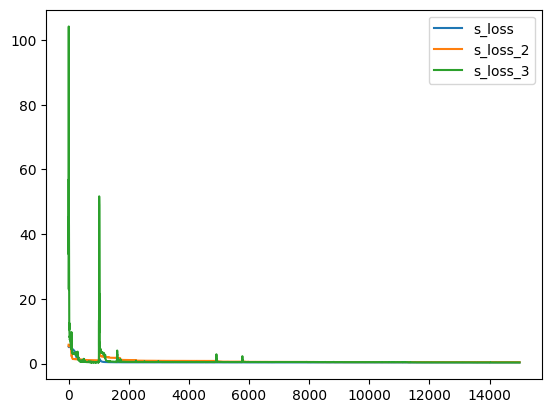

In [6]:
plt.plot(s_loss_list[0], label='s_loss')
plt.plot(s_loss_list[1], label='s_loss_2')
plt.plot(s_loss_list[2], label='s_loss_3')
plt.legend()
plt.show()

In [11]:
SIZE = 256
image_s2 =[]
dataset_s2=[]
image_labels2 = []

image_directory_22  = 'bad/'
bad_images = os.listdir(image_directory_22)
for i, image_name in enumerate(bad_images):
    if (image_name.endswith('png')):
        image_s2 = cv2.imread(image_directory_22 + image_name)
        image_s2 = Image.fromarray(image_s2,'RGB')
        image_s2 = image_s2.resize((SIZE, SIZE))
        dataset_s2.append(np.array(image_s2))
        
bad_dataset = np.array(dataset_s2)
bad_dataset = bad_dataset.astype('float32') / 255.

In [151]:
a = student_model.predict(bad_dataset)
b = t_model.predict(bad_dataset)


3/3 [==============================] - 0s 25ms/step


In [152]:
for i in range(3):
    globals()[f"a_{i}"] = np.array(a[i])
    globals()[f"b_{i}"] = np.array(b[i])
    

In [153]:
loss_0 = np.mean((a_0 - b_0)**2, axis=-1)
loss_1 = np.mean((a_1 - b_1)**2, axis=-1)
loss_2 = np.mean((a_2 - b_2)**2, axis=-1)

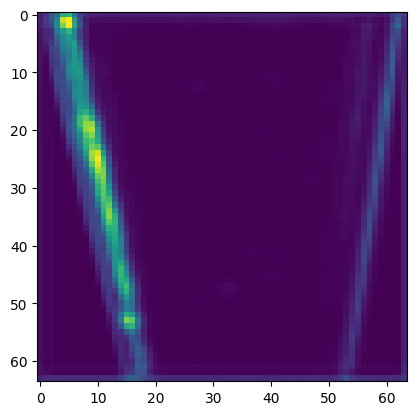

In [161]:
plt.imshow(loss_2[1])

In [44]:
import tensorflow as tf

loss_0 = tf.expand_dims(loss_0, axis =-1)
loss_1 = tf.expand_dims(loss_1, axis=-1)
loss_2 = tf.expand_dims(loss_2, axis=-1)
print(loss_0.shape)

upsampling_layer_2 = tf.keras.layers.UpSampling2D(size=(2, 2))
upsampling_layer_3 = tf.keras.layers.UpSampling2D(size=(4, 4))

up_loss_0 = loss_0
up_loss_1 = upsampling_layer_2(loss_1)
up_loss_2 = upsampling_layer_3(loss_2)


(77, 256, 256, 1)


In [45]:
print(up_loss_0.shape, up_loss_1.shape, up_loss_2.shape)



(77, 256, 256, 1) (77, 256, 256, 1) (77, 256, 256, 1)


In [69]:
from skimage import filters
def anomaly_map_roc(inp, outp):
    inp_gray = np.mean(inp, axis=2)
    outp_gray = np.mean(outp, axis=2)
    re = np.abs(inp - outp)**2
    re = np.mean(re, axis=-1, keepdims=True)
    inp_blurred = cv2.GaussianBlur(inp_gray, (3, 3), 0)
    thresh = filters.threshold_otsu(inp_blurred - 0.035)
    binary_image = (inp_blurred > thresh).astype(np.uint8) * 255
    contours, hierarchy = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    black = np.zeros_like(inp_gray)
    contour = cv2.drawContours(binary_image, contours, -1, (0, 0, 0), 2)
    contour_array = np.asarray(contour)
    for i in range (re.shape[0]):
        for j in range (re.shape[0]):
            if contour_array[i,j] == 0:
                re[i,j] = 0
    min_value = np.min(re)  
    max_value = np.max(re) 
    recon_error = re 
    normalized_x = (recon_error - min_value) / (max_value - min_value)
    anomaly_map = (recon_error - np.min(recon_error)) / (np.max(recon_error) - np.min(recon_error))
    return anomaly_map

In [47]:
result = []
for i in range(bad_dataset.shape[0]):
    result.append(anomaly_map_roc(bad_dataset[i], up_loss_0[i]))
result = np.array(result)

In [48]:
result_2 = []
for i in range(bad_dataset.shape[0]):
    result_2.append(anomaly_map_roc(bad_dataset[i], up_loss_1[i]))
result_2 = np.array(result_2)

In [49]:
result_3 = []
for i in range(bad_dataset.shape[0]):
    result_3.append(anomaly_map_roc(bad_dataset[i], up_loss_2[i]))
result_3 = np.array(result_3)

In [50]:
final = result*result_2*result_3

In [22]:
student_model.save('/home/aaslan/Trials/stud_teach.h5')


In [5]:
student_model = tf.keras.models.load_model('stud_teach.h5')

In [24]:
anomaly_map = up_loss_0 * up_loss_1 * up_loss_2

In [39]:
upsampling_layer = UpSampling2D(size=(2, 2))
upsampling_layer_2 = UpSampling2D(size=(4, 4))
from skimage import filters
def val_recon_countor(valdata):
    anomaly_val = []
    a = student_model.predict(valdata)
    b = t_model.predict(valdata)
    a_0 = np.array(a[0])
    b_0 = np.array(b[0])
    a_1 = upsampling_layer(a[1])
    a_2 = upsampling_layer_2(a[2])
    b_1 = upsampling_layer(b[1])
    b_2 = upsampling_layer_2(b[2])
    
    for i in range(valdata.shape[0]):
        inp_gray = np.mean(valdata[i], axis=2)
        inp_blurred = cv2.GaussianBlur(inp_gray, (3, 3), 0)
        thresh = filters.threshold_otsu(inp_blurred - 0.03)
        binary_image = (inp_blurred > thresh).astype(np.uint8) * 255
        contours, hierarchy = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        black = np.zeros_like(inp_gray)
        contour = cv2.drawContours(binary_image, contours, -1, (0, 0, 0), 2)
        contour_array = np.asarray(contour)
        recon_error_1 = np.mean((a_0[i] - b_0[i])**2, axis=-1)
        recon_error_2 = np.mean((a_1[i] - b_1[i])**2, axis=-1)
        recon_error_3 = np.mean((a_2[i] - b_2[i])**2, axis=-1)
        re = (recon_error_1) * (recon_error_2) * (recon_error_3)
        re[contour_array == 0] = 0  # Set reconstruction errors to 0 at black pixels in contour_array
        min_value = np.min(re)  
        max_value = np.max(re) 
        recon_error = re 
        normalized_x = (recon_error - min_value) / (max_value - min_value)
        re = (recon_error - np.min(recon_error)) / (np.max(recon_error) - np.min(recon_error))
        anomaly_val.append(re)
    
    anomaly_val = np.array(anomaly_val)
    return anomaly_val


In [ ]:
bad = val_recon_countor(bad_dataset)


3/3 [==============================] - 0s 25ms/step


In [ ]:
plt.imshow(bad[10], cmap='gray')

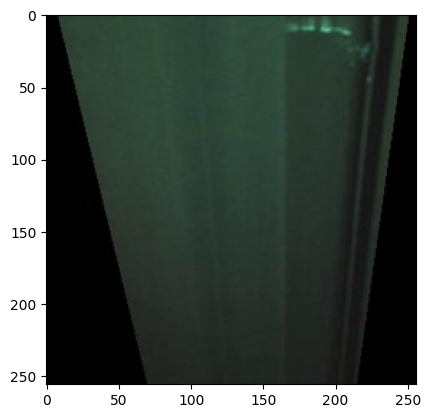

In [ ]:
plt.imshow(bad_dataset[46])

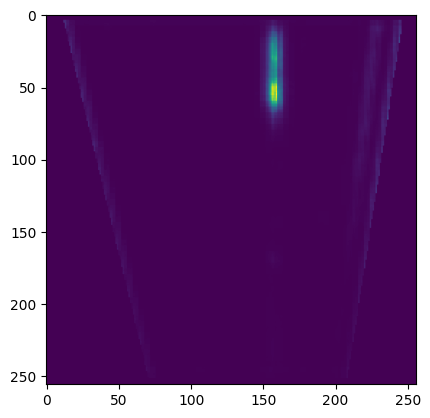

In [185]:
plt.imshow(test[15])

In [57]:
bad.shape

(77, 256, 256)

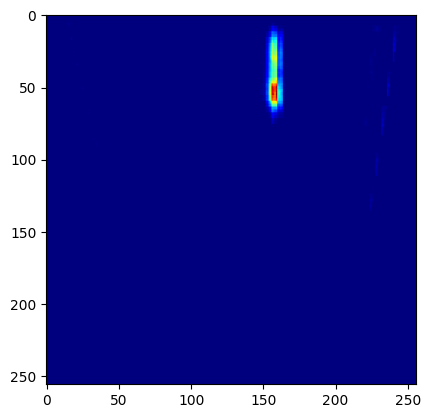

In [67]:
result = bad
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm  # Import the cm module for colormaps

heatmaps_array = np.zeros((result.shape[0], result.shape[1], result.shape[2], 3), dtype=np.uint8)

# Define your color thresholds
lower_threshold = 0.05  # Example value
upper_threshold = 1  # Example value

for i in range(result.shape[0]):
    anomaly_map = result[i, :, :]  # Assuming it's already normalized

    # Make a colormap that has your desired thresholds
    norm = colors.Normalize(vmin=lower_threshold, vmax=upper_threshold, clip=True)
    mapper = cm.ScalarMappable(norm=norm, cmap='jet')  # Replace 'jet' with any other colormap if you wish

    # Apply colormap to your data
    colored_map = mapper.to_rgba(anomaly_map)

    # Convert the colormap from RGBA to RGB, and scale to 8-bit
    colored_map = (colored_map[:, :, :3] * 255).astype(np.uint8)

    # Store the heatmap in the array
    heatmaps_array[i] = colored_map

plt.imshow(heatmaps_array[15])


In [8]:
student_model.save('newst.h5')

In [37]:
import os
import cv2

output_dir = 'outauto'
o_2 = 'org'

for i in range (bad.shape[0]):
    file_name = f"{i}.png"
    n_2 = f"{i}.png"

    file_path = os.path.join(output_dir, file_name)  # Combine directory path and file name
    file_path_2 = os.path.join(o_2, n_2)

    cv2.imwrite(file_path, bad[i]*255)

In [68]:
import os
import cv2

output_dir = 'outauto'
o_2 = 'org'

for i in range (result.shape[0]):
    file_name = f"{i}.png"
    n_2 = f"{i}.png"

    file_path = os.path.join(output_dir, file_name)  # Combine directory path and file name
    file_path_2 = os.path.join(o_2, n_2)
    rgb_map = cv2.cvtColor(heatmaps_array[i], cv2.COLOR_BGR2RGB)

    cv2.imwrite(file_path, rgb_map)

In [38]:
import shutil

def zip_file(file_path, zip_path):
    shutil.make_archive(zip_path, 'zip', file_path)

# Specify the file path and the desired zip file path
file_path = 'outauto'
zip_path = 'auto'

# Call the function to create the zip file
zip_file(file_path, zip_path)
